In [1]:
include("./modules/OpticalCavity.jl")
include("./modules/Thermodynamics.jl")
include("./modules/Phaseonium.jl")
include("./modules/BosonicOperators.jl")
include("./modules/Measurements.jl")

using LinearAlgebra
using SparseArrays
using ProgressBars
using Plots
using LaTeXStrings
# Saving the output matrix
using Serialization
using NPZ

using .OpticalCavity
using .Thermodynamics
using .Phaseonium
using .BosonicOperators
using .Measurements

include("./src/RoutineFunctions.jl")

## Setup Experiment

In [2]:
function kraus_operators(α, ϕ)
    ga, gb = Phaseonium.dissipationrates(α, ϕ)
    
    C = BosonicOperators.C(Ω*Δt, NDIMS)
    Cp = BosonicOperators.Cp(Ω*Δt, NDIMS)
    S = BosonicOperators.S(Ω*Δt, NDIMS)
    Sd = BosonicOperators.Sd(Ω*Δt, NDIMS)
    
    E0 = sqrt(1 - ga/2 - gb/2) * idd(NDIMS) 
    E1 = sqrt(ga/2) * C
    E2 = sqrt(ga) * S
    E3 = sqrt(gb/2) * Cp
    E4 = sqrt(gb) * Sd
    
    return [E0, E1, E2, E3, E4]
end

function bosonic_operators(α, ϕ)
    
    C = BosonicOperators.C(Ω*Δt, NDIMS)
    Cp = BosonicOperators.Cp(Ω*Δt, NDIMS)
    S = BosonicOperators.S(Ω*Δt, NDIMS)
    Sd = BosonicOperators.Sd(Ω*Δt, NDIMS)
    
    return [C, Cp, S, Sd]
end

function _check(ρ)
    println("System after the stroke:")
    if !checkdensity(ρ)
        throw(DomainError(ρ))
    end
    println("Final Temperature of the System: $(Measurements.temperature(ρ, ω))")
end

function measure_and_plot(system_evolution, cavity_evolution, title)
    temperatures = []
    entropies = []
    for (i, ρ) in enumerate(system_evolution)
        local ω = α0 / cavity_evolution[i] 
        t = round(Measurements.temperature(ρ, ω), digits=5)
        ent = round(Measurements.entropy_vn(ρ), digits=5)
        
        push!(temperatures, t)
        push!(entropies, ent)
    end
    
    g = plot(entropies, temperatures, label="Stroke")
    # Plot starting point
    scatter!(g, [entropies[1]], [temperatures[1]], label="Start", mc="blue", ms=5)
    # Plot ending point
    scatter!(g, [entropies[end]], [temperatures[end]], label="End", mc="red", ms=3)
    title!(title)
    xlabel!("Entropy")
    ylabel!("Temperature")
    display(g)
    
    return g
end
;

In [3]:
const NDIMS = 20
const Ω = 2.0
const Δt = 1e-2

const T_initial = 1.1
const T_heating = 1.5
const T_cooling = 1.0

# Create a Cavity
α0 = π
l0 = 1.0
expanding_force = 0.5
compressing_force = 2.5
cavity = Cavity(1.0, 1.0, l0, α0, expanding_force)
ω = α0 / l0

ρt = thermalstate(NDIMS, ω, T_initial)
println(
    "Initial Temperature of the Cavity:
    $(Measurements.temperature(ρt, ω))")

# Jump Operators
a = BosonicOperators.destroy(NDIMS)
ad = BosonicOperators.create(NDIMS)

# Create Phaseonium atoms
# For thermal (diagonal) phaseoniums, the Master Equation is the same as having ϕ=π/2
# Heating
ϕ_h = π/3
α_h = Phaseonium.alpha_from_temperature(T_heating, ϕ_h, ω) 

const ga_h, gb_h = Phaseonium.dissipationrates(α_h, ϕ_h)
println(
    "Apparent Temperature carried by Hot Phaseonium atoms: 
    $(Phaseonium.finaltemperature(ω, ga_h, gb_h))")

const kraus_h = kraus_operators(α_h, ϕ_h)
const bosonic_h = bosonic_operators(α_h, ϕ_h)

# Cooling
ϕ_c = π/4
α_c = Phaseonium.alpha_from_temperature(T_cooling, ϕ_c, ω) 

const ga_c, gb_c = Phaseonium.dissipationrates(α_c, ϕ_c)
println(
    "Apparent Temperature carried by Cold Phaseonium atoms: 
    $(Phaseonium.finaltemperature(ω, ga_c, gb_c))")

const kraus_c = kraus_operators(α_c, ϕ_c)
const bosonic_c = bosonic_operators(α_c, ϕ_c)

# Time Evolution loop
const TT = 20000  # Thermalization Time

system_evolution = []

# Check number of photons and cutoff
println("Last element: $(ρt[end])")
println("Avg n: $(tr(ρt*ad*a))")

Initial Temperature of the Cavity:
    1.1
Apparent Temperature carried by Hot Phaseonium atoms: 
    1.4999999999999998
Apparent Temperature carried by Cold Phaseonium atoms: 
    1.0000000000000002
Last element: 2.5572978336914355e-24
Avg n: 0.06100646942057417


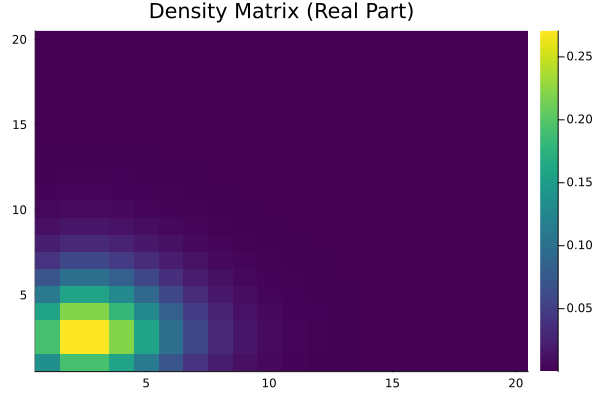

Last element: 5.832924198269287e-13 + 0.0im
Avg n: 1.9999999999987046 + 0.0im


In [4]:
# Coherent State
alpha = sqrt(2)  # Coherent state parameter
# Gaussian state
ρg = coherentstate(alpha, NDIMS)
g = heatmap(real(ρg), color=:viridis, title="Density Matrix (Real Part)")
display(g)
println("Last element: $(ρg[end])")
println("Avg n: $(tr(ρg*ad*a))")

## 1) Isochoric Stroke

In [5]:
# See if it has thermalized
# system_final = Thermodynamics.phaseonium_stroke(stroke_evolution[end], 5, kraus_h; sampling_steps=5, verbose=0)[end];
# _check(system_final)

## 2) Adiabatic Expansion

## 3) Isochoric Cooling

## 4) Adiabatic Compression

## Full Cycle

1.5000000000004257
0.14043903442323719


20×20 SparseMatrixCSC{Float64, Int64} with 11 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠑⠄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎦

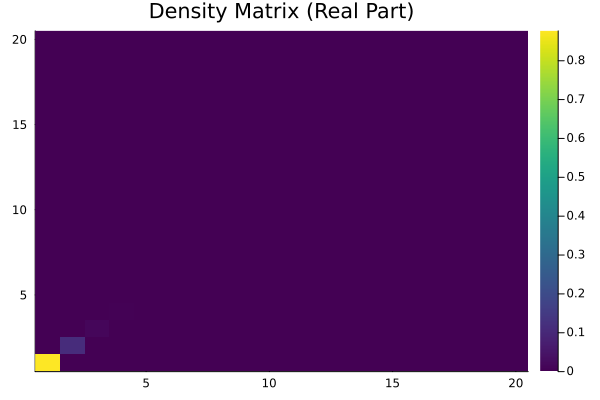

In [6]:
ρ = copy(ρg)
systems = [Matrix(ρ) for _ in 0:100]
dimensions = size(ρ)
temp1 = spzeros(ComplexF64, dimensions)
for _ in 1:100000
    # Reset the new density operator
    temp2 = spzeros(dimensions)
    for ek in kraus_h
        mul!(temp1, ek, ρ)  # left multiplication
        mul!(temp1, temp1, ek')  # right multiplication
        temp2 .+= temp1
    end
    ρ = temp2  # updates the old density operator
end
chop!(ρ)

println(Measurements.temperature(real(ρ), ω))
println(tr(ρ * ad*a))
display(ρ)
heatmap(real(ρ), color=:viridis, title="Density Matrix (Real Part)")

In [7]:
cycle_evolution = []
cavity_evolution = []
ρ = ρg
# Decomposed in three parts (constant and rotating)
n = ad * a
π_a = a * a
π_ad = ad * ad
π_parts = (n, π_a, π_ad)

isochore_time = 100000
isochore_samplings = 100
adiabatic_time = 1000
adiabatic_samplings = 10
for t in 1:20
    println("Cycle $t")
    # Isochoric Heating
    stroke_evolution = Thermodynamics.phaseonium_stroke(ρ, TT, kraus_h; sampling_steps=isochore_samplings, verbose=1)
    append!(cycle_evolution, stroke_evolution)
    append!(cavity_evolution, [cavity.length for _ in stroke_evolution])
    ρ = stroke_evolution[end]
    chop!(ρ)
    # Adiabatic Expansion
    stroke_evolution, cavity_expansion = Thermodynamics.adiabatic_stroke(
        ρ, 100, Δt, [a, ad], cavity, idd(NDIMS), π_parts;
        sampling_steps=adiabatic_samplings, verbose=1)
    append!(cycle_evolution, stroke_evolution)
    append!(cavity_evolution ,cavity_expansion)
    ρ = stroke_evolution[end]
    chop!(ρ)
    # Isochoric Cooling
    stroke_evolution = Thermodynamics.phaseonium_stroke(ρ, TT, kraus_c; sampling_steps=isochore_samplings, verbose=1)
    append!(cycle_evolution, stroke_evolution)
    append!(cavity_evolution, [cavity.length for _ in stroke_evolution])
    ρ = stroke_evolution[end]
    chop!(ρ)
    # Adiabatic Compression
    # cavity.external_force = compressing_force
    stroke_evolution, cavity_compression = Thermodynamics.adiabatic_stroke(
        ρ, 100, Δt, [a, ad], cavity, idd(NDIMS), π_parts; 
        sampling_steps=adiabatic_samplings, verbose=1)
    append!(cycle_evolution, stroke_evolution)
    append!(cavity_evolution, cavity_compression)
    ρ = stroke_evolution[end]
    chop!(ρ)
end

Cycle 1
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 2
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 3
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 4
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 5
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 6
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 7
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 8
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 9
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 10
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 11
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 12
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 13
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 14

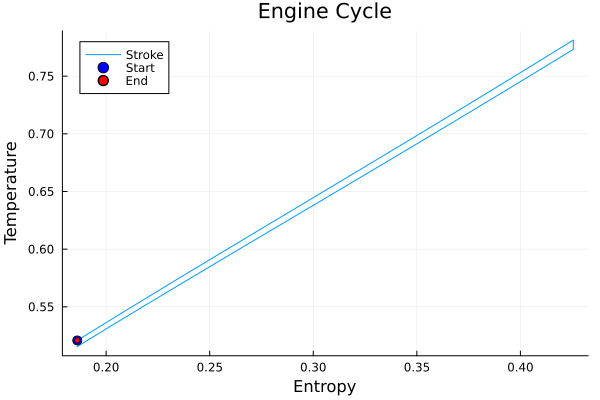

In [8]:
cycle_time = 2*isochore_samplings + 2*adiabatic_samplings + 3
g = measure_and_plot(cycle_evolution[end - cycle_time:end], cavity_evolution[end - cycle_time:end], "Engine Cycle");
savefig("img/phaseonium_engine_cycle");

In [9]:
state = StrokeState(ρ, cavity, cavity)
state.ρ₁_evolution = cycle_evolution
state.c₁_evolution = cavity_evolution
serialize("single_coherent/state_20cycles", state);